<div style="font-family: 'TeX Gyre Termes', serif; color: black; font-size: 18px;">

### **Task I: Hyperspectral Classification on Pavia University Dataset**  
**Author: Ramesh Bhatta, CIS, RIT**  
**Github Repo: https://github.com/Bhatta6190/Machine-Learning-in-Remote-Sensing/tree/main/HSI-classification-regression/Classification**  

</div>

<div style="font-family: 'TeX Gyre Termes', serif; color: black; font-size: 18px;">

---
---

### **Task Definition**  

The Pavia University dataset is a hyperspectral image dataset which gathered by a sensor known as the reflective optics system imaging spectrometer (ROSIS-3) over the city of Pavia, Italy. The image consists of **610×340** pixels with **103 spectral bands**. The number of classes and the corresponding number of samples are shown below and as you can see, the dataset is imbalanced. The ROSIS sensor collects between **430-960 nanometer** in **5 nano meter spectral spacing**. 

In this Task we will use the Pavia University dataset (*PaviaU.mat* and *PaviaU_gt.mat*) to perform:

- **Exploratory Data Analysis (EDA)**
- **Binary Classification using Logistic Regression**
- **Multi-class classification using XGBoost Algorithm**

---
---

</div>


In [1]:
## Importing Necessary Libraries

import numpy as np
import scipy.io  
import matplotlib.pyplot as plt  
import seaborn as sns  

from sklearn.preprocessing import StandardScaler, label_binarize  

import xgboost as xgb  
from xgboost import XGBClassifier  
from sklearn.linear_model import LogisticRegression  

from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    roc_curve, auc
)

from sklearn.model_selection import train_test_split  


In [2]:
## Predefined plot preferences

# Define text sizes
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

# Apply text size settings
plt.rc('font', size=SMALL_SIZE)          # Default font size
plt.rc('axes', titlesize=MEDIUM_SIZE)   # Axis title font size
plt.rc('axes', labelsize=MEDIUM_SIZE)   # Axis labels font size
plt.rc('xtick', labelsize=SMALL_SIZE)   # X-axis tick label font size
plt.rc('ytick', labelsize=SMALL_SIZE)   # Y-axis tick label font size
plt.rc('legend', fontsize=SMALL_SIZE)   # Legend font size
plt.rc('figure', titlesize=BIGGER_SIZE) # Figure title font size

<div style="font-family: 'TeX Gyre Termes', serif; color: black; font-size: 18px;">

---
---

### **Exploratory Data Analysis (EDA)**


</div>


In [3]:
## Performing EDA on given HSI Dataset

# Import the dataset
pavia_data = scipy.io.loadmat('PaviaU.mat')
pavia_gt = scipy.io.loadmat('PaviaU_gt.mat')

# Load the HSI data
hsi_data = pavia_data['paviaU']
hsi_gt = pavia_gt['paviaU_gt']

In [12]:
## Assuming Linear spacing between bands, converting bands to wavelength

start_wavelength = 430  # nm
end_wavelength = 960    # nm
band_spacing = 5        # nm

# Generate wavelength values for all bands
num_bands = (end_wavelength - start_wavelength) // band_spacing + 1
wavelengths = np.arange(start_wavelength, end_wavelength + band_spacing, band_spacing)

# Print the bands with their corresponding wavelengths
print("First 10 Bands Mapping:")
for band, wavelength in enumerate(wavelengths[:10]):
    print(f"Band {band}: {wavelength} nm")
print("... ... ...")

First 10 Bands Mapping:
Band 0: 430 nm
Band 1: 435 nm
Band 2: 440 nm
Band 3: 445 nm
Band 4: 450 nm
Band 5: 455 nm
Band 6: 460 nm
Band 7: 465 nm
Band 8: 470 nm
Band 9: 475 nm
... ... ...


<div style="font-family: 'TeX Gyre Termes', serif; color: black; font-size: 18px;">

**NOTE:** The linear spacing between bands assumption gives a total of 107 (0-106) bands between 430 nm to 960 nm at a spacing of 5 nm. This mapping will be used for visualization purpose only. 
</div>

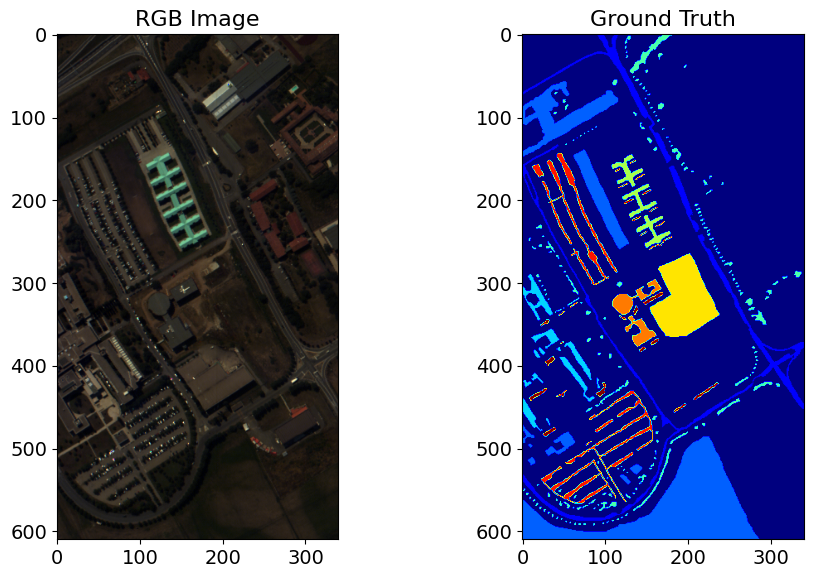

In [ ]:
## Plotting the data

# Select RGB bands from band to wavelength mapping
rgb_image = np.stack((hsi_data[:, :, 44], hsi_data[:, :, 24], hsi_data[:, :, 4]), axis=-1)

# Normalization
rgb_image = (rgb_image - np.min(rgb_image)) / (np.max(rgb_image) - np.min(rgb_image))

# Plot RGB and ground truth
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

ax[0].imshow(rgb_image)
ax[0].set_title("RGB Image")

ax[1].imshow(hsi_gt, cmap="jet")
ax[1].set_title("Ground Truth")

plt.tight_layout()
plt.show()

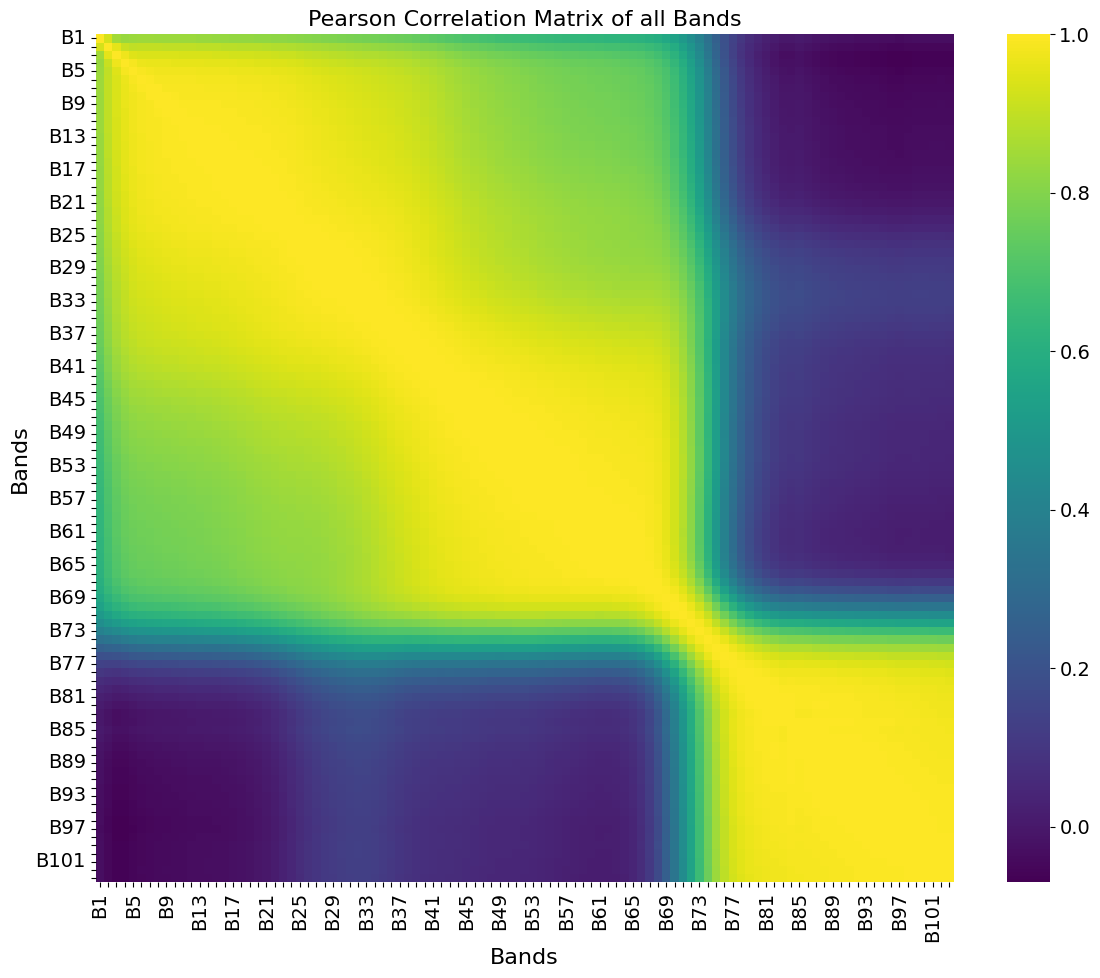

In [ ]:
## Plot the correlation Matrix

def correlation_matrix(band_data):

    bands = band_data.shape[2]
    reshaped_data = band_data.reshape(-1, bands) 
    reshaped_data = reshaped_data[~np.isnan(reshaped_data).any(axis=1)]  
    corr_matrix = np.corrcoef(reshaped_data, rowvar=False)

    return corr_matrix

# Compute the correlation matrix for HSI data data
correlation_matrix = correlation_matrix(hsi_data)

# Add ticks at certain spacing for better visuals
xticks = [f'B{i+1}' for i in range(hsi_data.shape[2])]
step = max(1, len(xticks) // 25)  # Show labels at intervals
xticks_labels = [xticks[i] if i % step == 0 else "" for i in range(len(xticks))]

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap="viridis", cbar=True,
            xticklabels=xticks_labels, yticklabels=xticks_labels)
plt.title("Pearson Correlation Matrix of all Bands")
plt.xlabel("Bands")
plt.ylabel("Bands")
plt.tight_layout()
plt.show()

<div style="font-family: 'TeX Gyre Termes', serif; color: black; font-size: 18px;">

**COMMENTS:**  

The correlation image (matrix) shown above shows the strength of correlation between individual bands in the hyperspectral imagery. We can clearly see the cluster of high correlation bands in the plot. Specially the bands within range *B1-B70* and *B80-B103* show high degree of correlation. Also within the first cluster of high correlation there are smaller clusters of highly correlated band *(corr > 90%)*, for example B5-B40. Such highly correlated bands represent redundant information in the data (Multi-collinearity) and fewer bands can be used for designing an efficient machine learning model- both in classification and regression. Again PCA or other dimensionality reduction techniques can also be used for such tasks.
</div>

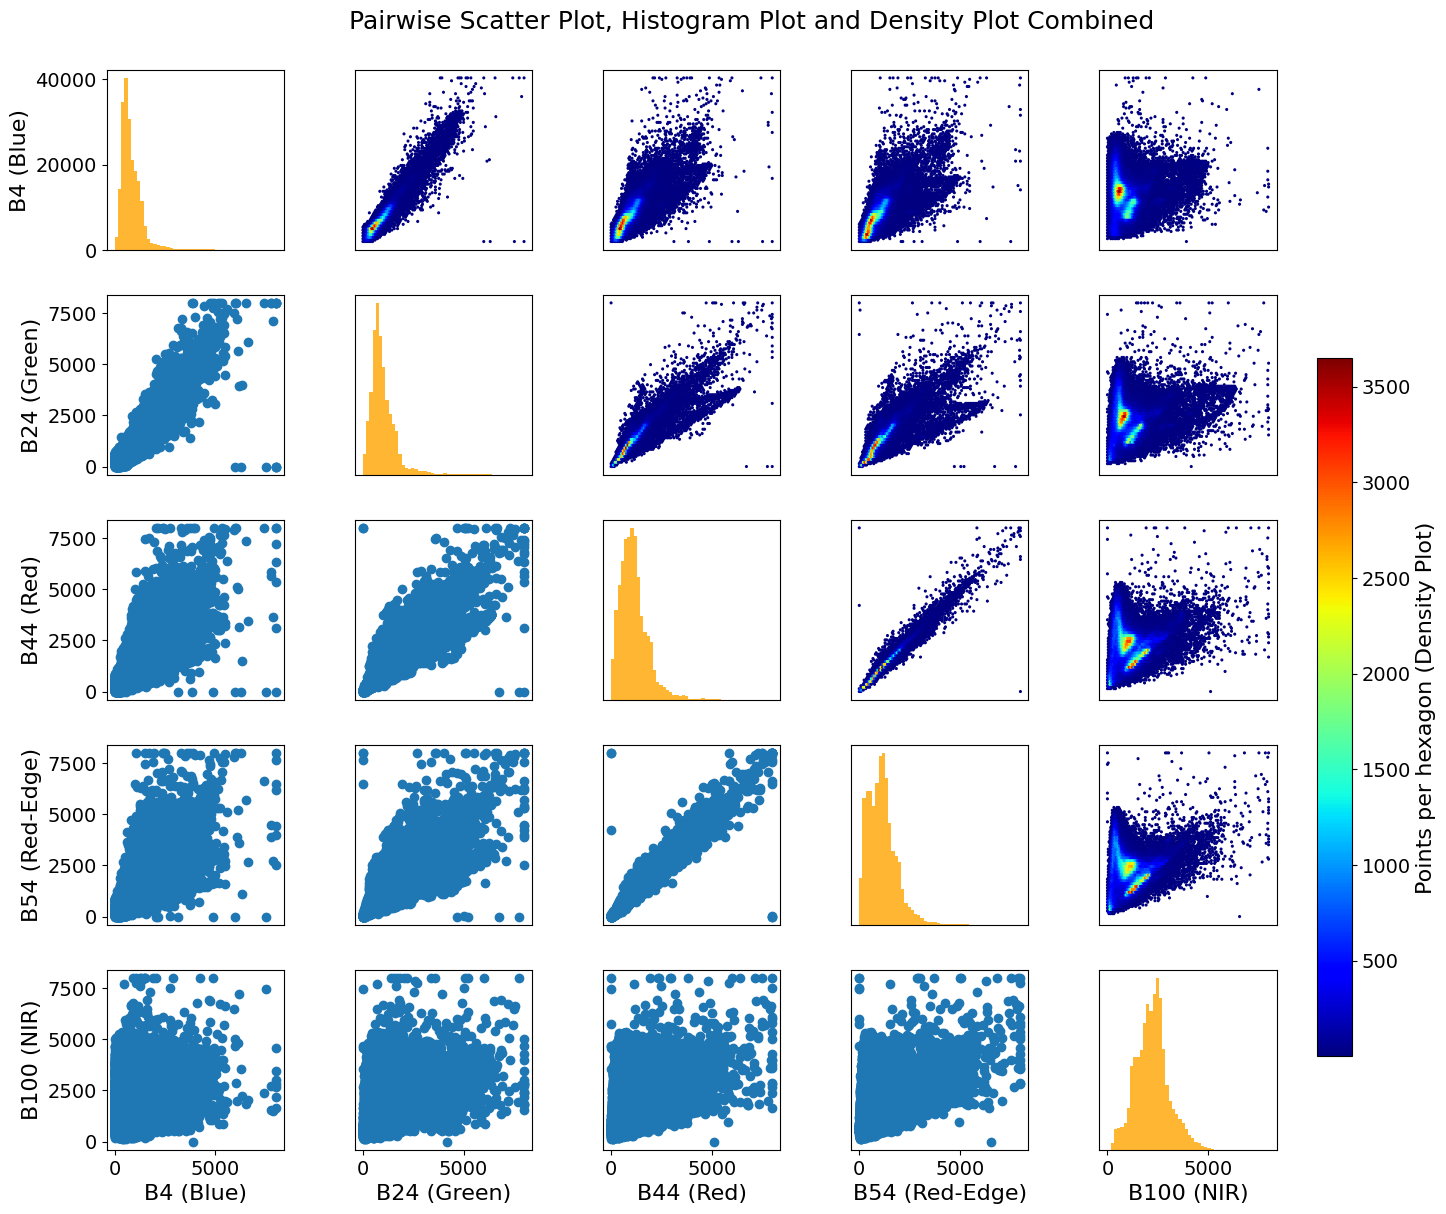

In [ ]:
## Plotting Scatter and Density plot for important bands: "B4 (Blue)", "B24 (Green)", "B44 (Red)", "B54 (Red-Edge)" and  "B100 (NIR)"

def correlation_plot(band_data, band_names):

    num_bands = len(band_data)
    fig, axes = plt.subplots(num_bands, num_bands, figsize=(15, 15))
    fig.suptitle("Pairwise Scatter Plot, Histogram Plot and Density Plot Combined", y=0.96)

    density_plots = []

    ## For all Bands
    for i in range(num_bands):
        for j in range(num_bands):
            ax = axes[i, j]

            # Plot Histogram in Diagonal
            if i == j:
                ax.hist(band_data[i], bins=50, color='orange', alpha=0.8)

            # Density plot in upper triangle--> Using histogram based density plot (hexbin plot)
            elif i < j:
                x = band_data[i]
                y = band_data[j]
                
                # Hexbin density plot
                hb = ax.hexbin(x, y, gridsize=100, cmap='jet', mincnt=1) ## 100 hexagonal grids
                density_plots.append(hb)    # For combined color bar
                
                # Set axis off for clear visuals
                ax.set_xticks([])
                ax.set_yticks([])

            # Scatter Plot in Lower Triangle
            elif i > j:
                ax.scatter(band_data[j], band_data[i])

            # Cleaner Visuals
            if j != 0:
                ax.set_yticks([])
            if i != num_bands - 1:                 ## Remove ticks
                ax.set_xticks([])

            if i == num_bands - 1:
                ax.set_xlabel(band_names[j])       ## Name/Label only on
            if j == 0:
                ax.set_ylabel(band_names[i])
                
    if density_plots:
        cbar = fig.colorbar(density_plots[0], ax=axes, orientation='vertical', fraction=0.03, pad=0.05)
        cbar.set_label('Points per hexagon (Density Plot)')

    fig.subplots_adjust(hspace=0.25, wspace=0.4, top=0.92, bottom=0.20, left=0.07, right=0.85)
    plt.show()


# Extracting and cleaning the 10m bands
B4 = hsi_data[:, :, 4].flatten()
B24 = hsi_data[:, :, 24].flatten()
B44 = hsi_data[:, :, 44].flatten()
B54 = hsi_data[:, :, 54].flatten()
B100 = hsi_data[:, :, 100].flatten()

# Removing NaNs
B4_clean = B4[~np.isnan(B4)]
B24_clean = B24[~np.isnan(B24)]              
B44_clean = B44[~np.isnan(B44)]
B54_clean = B54[~np.isnan(B54)]
B100_clean = B100[~np.isnan(B100)]

# Prepare data and labels
band_data = [B4_clean, B24_clean, B44_clean,B54_clean, B100_clean]
band_names = ["B4 (Blue)", "B24 (Green)", "B44 (Red)", "B54 (Red-Edge)",  "B100 (NIR)"]

# Calling the function
correlation_plot(band_data, band_names)


<div style="font-family: 'TeX Gyre Termes', serif; color: black; font-size: 18px;">

**COMMENTS:**  

For gaining some insights on band correlations we plotted Scatter and Density plot for few bands: "B4 (Blue)", "B24 (Green)", "B44 (Red)", "B54 (Red-Edge)" and  "B100 (NIR)". The data is in raw digital numbers and the distribution looks fairly normal across the 5 bands. As mentioned above the band collinearities are clearly visible in the scatterplots with some bands having high collinearity (Blue-Green and Red-RedEdge). The densities are higher at lower values with the presence of some extreme pixels too. Also A noticeable *Tasseled-Cap* distribution can be seen in Red vs NIR density plot which indicates presence of different materials like healthy vegetations, bare soil, water(or wet soil) and so on in the scene. Overall, the dataset does not contain any anomalies that require immediate attention.
</div>

<div style="font-family: 'TeX Gyre Termes', serif; color: black; font-size: 18px;">

---
---


### **Binary Classification**

We will classify the dataset into two classes- *vegetation class (class 2, 4)* and *Non-Vegetation class (remaining classes)* using *Logistic Regression Model*.

Classes Contained in Dataset:

    1. Asphalt
    2. Meadows
    3. Gravel
    4. Trees
    5. Painted Metal sheets
    6. Bare soil
    7. Bitumen
    8. Self-Blocking Bricks
    9. Shadows

`Features Used: Blue, Green, Red, Red-Edge and NIR Band`.

</div>


In [ ]:
## Ground Truth Analysis

unique_classes = np.unique(hsi_gt)  # Unique classes in ground data
print("Class labels:", unique_classes)

Class labels: [0 1 2 3 4 5 6 7 8 9]


In [ ]:
## Dumping class zero pixels from ground truth data

m, n = hsi_gt.shape 
flattened_gt = hsi_gt.reshape(m * n)

# Mask 0 pixels (keep only valid pixels)
valid_mask = ~(flattened_gt==0)
valid_gt_pixels = flattened_gt[valid_mask]

print(f"Number of valid labels: {len(valid_gt_pixels)}")

## Removing the zero class pixels from hsi_data

flattened_hsi_data = hsi_data.reshape(m*n, hsi_data.shape[2])
valid_hsi_data = flattened_hsi_data[valid_mask]
print(f"Valid pixel dimension in hsi_data: {valid_hsi_data.shape}")

## Taking band in the blue, green, red, red-edge, and near-infrared region

selected_band_indices = [4, 24, 44, 54, 100] ## Band indices 
valid_hsi_data_subsetted = valid_hsi_data[:, selected_band_indices] ## subsetting to given bands

Number of valid labels: 42776
Valid pixel dimension in hsi_data: (42776, 103)


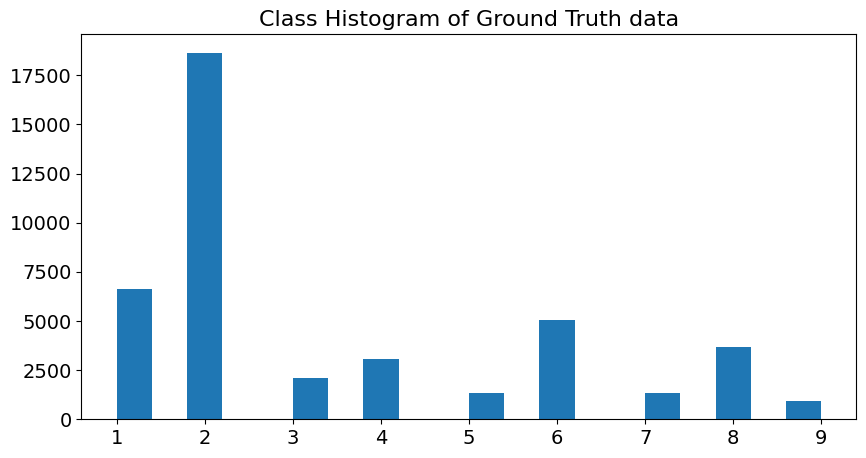

In [ ]:
## Plotting the class distribution

plt.figure(figsize=(10, 5))
plt.hist(valid_gt_pixels, bins=20, histtype='stepfilled')
plt.title(f'Class Histogram of Ground Truth data')
plt.show()

In [ ]:
## Each class samples:

from collections import Counter

# Count samples in each class
class_counts = Counter(valid_gt_pixels)
print(f"Original class distribution: {class_counts}")

Original class distribution: Counter({np.uint8(2): 18649, np.uint8(1): 6631, np.uint8(6): 5029, np.uint8(8): 3682, np.uint8(4): 3064, np.uint8(3): 2099, np.uint8(5): 1345, np.uint8(7): 1330, np.uint8(9): 947})


<div style="font-family: 'TeX Gyre Termes', serif; color: black; font-size: 18px;">

**Need of Class Balancing:**  

As we can see from the histogram of classes of interest there is high imbalance in the data with class 2 (Meadows) having 18649 samples while class 9 (shadow) having just 947 samples. If we train any machine learning algorithm keeping this dataset as it is, during training the algorithm will *"see"* the classes with higher number of samples much often than the classes with lower number of samples. This introduces bias in the model and the model tends to favor the majority class and results in poor performance during testing for the minority class. In other words the model fails to learn meaningful patterns in the minority class and leads to poor generalization on unseen data.

To avoid such problem we need to make sure that the model *"sees"* similar number of samples from all the classes i.e. we need to *Balance the dataset*. Here we are using **Random Undersampling** of the dataset. It means we are randomly undersampling the majority class samples to match with the number of minority class samples.
</div>

In [ ]:
## Taking band in the blue, green, red, red-edge, and near-infrared region for the analysis:

selected_band_indices = [4, 24, 44, 54, 100] ## Band indices 
valid_hsi_data_subsetted = valid_hsi_data[:, selected_band_indices] ## subsetting

In [ ]:
## Using Random Undersampling for class balancing

from sklearn.utils import resample

target_size = 947 ## Setting it to Smallest class size i.e. class 9: Shadows

## Function to randomunder sample to smallest class size 

def randomUS(multiband_pixels, gt_pixel):

    undersampled_data = []
    undersampled_labels = []

    unique_classes = np.unique(gt_pixel)

    for cls in unique_classes:

        class_mask = gt_pixel == cls
        class_data = multiband_pixels[class_mask]
        class_labels = gt_pixel[class_mask]

        # Random undersampling to target size
        class_data_resampled, class_labels_resampled = resample(
            class_data, class_labels,
            replace=False,  # No replacement (undersampling)
            n_samples=target_size,
            random_state=42
        )

        undersampled_data.append(class_data_resampled)
        undersampled_labels.append(class_labels_resampled)

    # Convert to numpy arrays
    undersampled_data = np.vstack(undersampled_data)
    undersampled_labels = np.hstack(undersampled_labels)

    return undersampled_data, undersampled_labels

In [ ]:
## Undersample the band selected data:

undersampled_original_data, undersampled_original_data_labels = randomUS(valid_hsi_data_subsetted, valid_gt_pixels)
print(f"New dataset shape: {undersampled_original_data.shape}, Labels shape: {undersampled_original_data_labels.shape}")

New dataset shape: (8523, 5), Labels shape: (8523,)


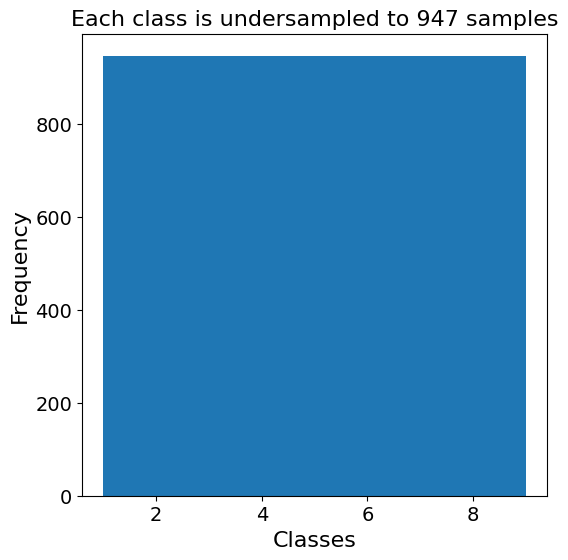

In [ ]:
## Class Distribution After Balancing

plt.figure(figsize=(6, 6))
plt.hist(undersampled_original_data_labels.flatten(), bins=9, histtype='stepfilled')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title(f'Each class is undersampled to {target_size} samples')
plt.show()


<div style="font-family: 'TeX Gyre Termes', serif; color: black; font-size: 18px;">

**Random Undersampling Outcome:** 

We can see from class balanced data histogram above that after class balancing the number of samples in each class is same and hence now we are ready to train our ML model for classification task. The reason for choosing Random Undersampling is that we dont want to synthesize the data (oversample) as long as we already have enough samples in our original data for working on models which dont require huge data samples. 

</div>

In [ ]:
## Seperate into classes of interest

veg_classes = [2, 4]  # Trees & Meadows

# Assign binary labels: 1 for vegetation, 0 for non-vegetation
binary_labels = np.isin(undersampled_original_data_labels, veg_classes).astype(int)

print(f"Class distribution after binarization: {np.bincount(binary_labels)}")

Class distribution after binarization: [6629 1894]


In [ ]:
## Function to perform Logistic-Regression on given 'data' and corresponding 'labels'

def logistic_reg_fun(data, labels):

    ## 80-20 split
    X_train, X_test, y_train, y_test = train_test_split(
        data, labels, 
        test_size=0.2, random_state=42, stratify=labels
    )

    print(f"Train size: {X_train.shape}, Test size: {X_test.shape}\n")

    # Train the logistic regression model usins scikit-learn Model
    log_reg = LogisticRegression(random_state=42)
    log_reg.fit(X_train, y_train)

    # Make predictions on test set
    y_train_pred = log_reg.predict(X_train)
    y_test_pred = log_reg.predict(X_test)

    # Get prediction probabilities for ROC curve
    y_test_prob = log_reg.predict_proba(X_test)[:, 1]  # Probabilities for class 1 (Vegetation)

    ## Evaluation metrics:

    # Training and Testing Performance
    print("\033[1mTraining Performance:\033[0m")
    print(classification_report(y_train, y_train_pred))

    print("\n\033[1mTesting Performance:\033[0m")
    print(classification_report(y_test, y_test_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(1, 2), yticklabels=range(1, 2))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='red', lw=1, label=f'AUC = {roc_auc:.2f}', linestyle='--')
    plt.plot([0, 1], [0, 1], color='g', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.grid(which='both')
    plt.minorticks_on()
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Logistic Regression')
    plt.legend(loc='lower right')
    plt.show()

    return None

Train size: (6818, 5), Test size: (1705, 5)

Training Performance:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      5303
           1       0.89      0.87      0.88      1515

    accuracy                           0.95      6818
   macro avg       0.92      0.92      0.92      6818
weighted avg       0.95      0.95      0.95      6818


Testing Performance:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1326
           1       0.86      0.87      0.86       379

    accuracy                           0.94      1705
   macro avg       0.91      0.91      0.91      1705
weighted avg       0.94      0.94      0.94      1705



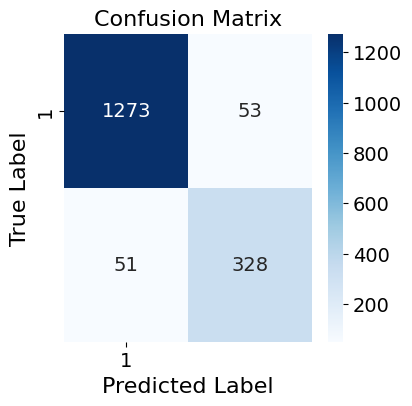

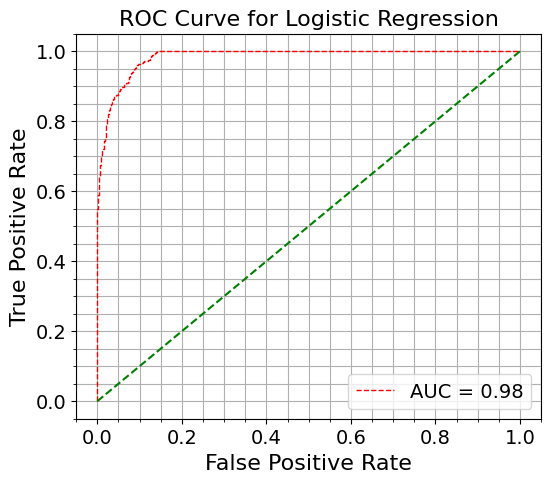

In [ ]:
## Run for Undersampled (Balanced) data:

logistic_reg_fun(undersampled_original_data, binary_labels)


<div style="font-family: 'TeX Gyre Termes', serif; color: black; font-size: 18px;">

**Model Analysis:** 
 
After undersampling the data to contain equal samples of all classes we binarize the dataset into *vegetation* and *non-vegetation* classes by assigning **1** for vegetation, **0** for non-vegetation class and used 80-20 split for training and testing the *logistic regression model*. The outcomes of the tasks are presented above. We can see the model performs very well with training and testing accuracies above *90%*. From confusion matrix we can see that there are some samples where class 1 is confused with class 0 during prediction (53 samples) and vice-versa (51 samples). The *Area under curve (AUC)* metric shows a near perfect classificatio with a value of 0.98. As a whole this classification works quite well both in training as well as testing dataset which means a good generalization (balance between variance and bias).
</div>

<div style="font-family: 'TeX Gyre Termes', serif; color: black; font-size: 18px;">

**Does Standarization and Outlier Removal Help in Improving Performance ??** 

</div>


Train size: (6532, 5), Test size: (1634, 5)

Training Performance:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      5026
           1       0.89      0.86      0.87      1506

    accuracy                           0.94      6532
   macro avg       0.92      0.91      0.92      6532
weighted avg       0.94      0.94      0.94      6532


Testing Performance:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1257
           1       0.86      0.87      0.87       377

    accuracy                           0.94      1634
   macro avg       0.91      0.91      0.91      1634
weighted avg       0.94      0.94      0.94      1634



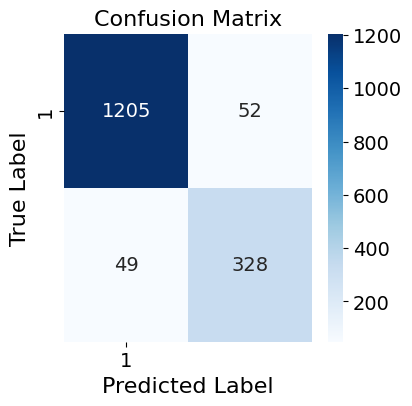

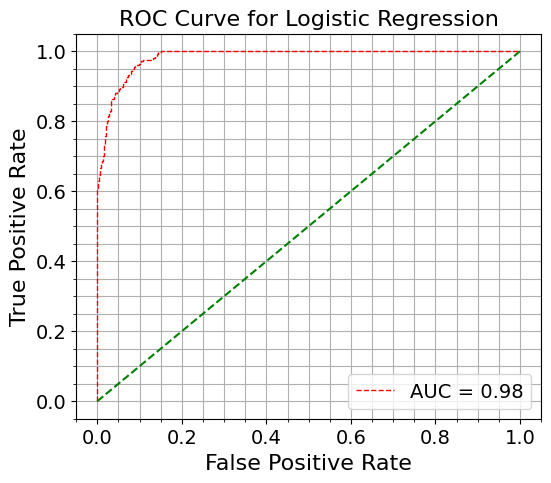

In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(undersampled_original_data) # Get z-scores (z = x - u / s)
z_scores = np.abs(X_scaled) # Get absolute value of z-scores

# Non-Outlier Indices
non_outlier_indices = np.all(z_scores < 3, axis=1)  ## Threshold = 3

# Remove Outliers
X_clean = X_scaled[non_outlier_indices]
y_clean = binary_labels[non_outlier_indices]

# Call the logistic Regression Function
logistic_reg_fun(X_clean, y_clean)

<div style="font-family: 'TeX Gyre Termes', serif; color: black; font-size: 18px;">

**Comments:** We tested if standarization and outlier removal improves the model. The answer is "no" and such data removal technique wont necessrily improve the classification outcome. The results are similar and it is also to be noted that this process reduces number of samples available for training and testing for our model. 

</div>

<div style="font-family: 'TeX Gyre Termes', serif; color: black; font-size: 18px;">

---
---


### **Multiclass Classification**

We will classify the dataset into all 9 classes mentioned below using *XGBoost Classification Algorithm*.

    1. Asphalt
    2. Meadows
    3. Gravel
    4. Trees
    5. Painted Metal sheets
    6. Bare soil
    7. Bitumen
    8. Self-Blocking Bricks
    9. Shadows

`Features Used: Blue, Green, Red, Red-Edge and NIR Band`.

</div>

In [ ]:
## XGBoost Classification:

## Function to perform XGBoost Classification and show performance metrics:

def XGBoost_classification(data, labels):

    # Perform 80-20 train-test split while maintaining class distribution
    X_train, X_test, y_train, y_test = train_test_split(
        data, labels, 
        test_size=0.2, random_state=42, stratify=labels
    )

    # Print class distribution after splitting
    unique_classes, train_counts = np.unique(y_train, return_counts=True)
    _, test_counts = np.unique(y_test, return_counts=True)

    print("Train class distribution:", dict(zip(unique_classes, train_counts)))
    print("Test class distribution:", dict(zip(unique_classes, test_counts)))

    print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

    # Shift labels to start from 0 instead of 1 (as XGBoost in scikit-learn expects this format of labels)
    y_train_adjusted = y_train - 1
    y_test_adjusted = y_test - 1

    # Define XGBoost model 
    model = XGBClassifier(objective="multi:softmax", num_class=9, eval_metric="mlogloss")

    # Train the model
    model.fit(X_train, y_train_adjusted)

    # Predictions
    y_train_pred_adjusted = model.predict(X_train)
    y_test_pred_adjusted = model.predict(X_test)

    # Convert back to original labels (1-9)
    y_train_pred = y_train_pred_adjusted + 1
    y_test_pred = y_test_pred_adjusted + 1

    # Prediction probabilities
    y_test_prob = model.predict_proba(X_test)

    # Print training performance
    print("\n\033[1mTraining Performance:\033[0m")
    print(classification_report(y_train, y_train_pred))

    # Print testing performance
    print("\n\033[1mTesting Performance:\033[0m")
    print(classification_report(y_test, y_test_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(1, 10), yticklabels=range(1, 10))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # XGBoost Feature Importance 
    xgb.plot_importance(model, importance_type='gain', max_num_features=10)  
    plt.title("Feature Importance (Gain)")
    plt.show()

    # Compute ROC Curve for Multi-Class
    n_classes = 9  # Number of classes
    y_test_bin = label_binarize(y_test, classes=range(1, n_classes + 1))  # One-hot encode true labels

    plt.figure(figsize=(8, 6))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i+1} (AUC = {roc_auc:.2f})')

    # Plot diagonal line
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

    # Formatting
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for XGBoost Multi-Class Classification')
    plt.legend(loc='lower right')
    plt.grid(which='both')
    plt.minorticks_on()
    plt.show()
    
    return None

Train class distribution: {np.uint8(1): np.int64(5305), np.uint8(2): np.int64(14919), np.uint8(3): np.int64(1679), np.uint8(4): np.int64(2451), np.uint8(5): np.int64(1076), np.uint8(6): np.int64(4023), np.uint8(7): np.int64(1064), np.uint8(8): np.int64(2945), np.uint8(9): np.int64(758)}
Test class distribution: {np.uint8(1): np.int64(1326), np.uint8(2): np.int64(3730), np.uint8(3): np.int64(420), np.uint8(4): np.int64(613), np.uint8(5): np.int64(269), np.uint8(6): np.int64(1006), np.uint8(7): np.int64(266), np.uint8(8): np.int64(737), np.uint8(9): np.int64(189)}
Train size: (34220, 5), Test size: (8556, 5)

Training Performance:
              precision    recall  f1-score   support

           1       0.98      0.97      0.98      5305
           2       0.91      0.98      0.94     14919
           3       0.90      0.83      0.86      1679
           4       0.96      0.93      0.95      2451
           5       1.00      1.00      1.00      1076
           6       0.94      0.67     

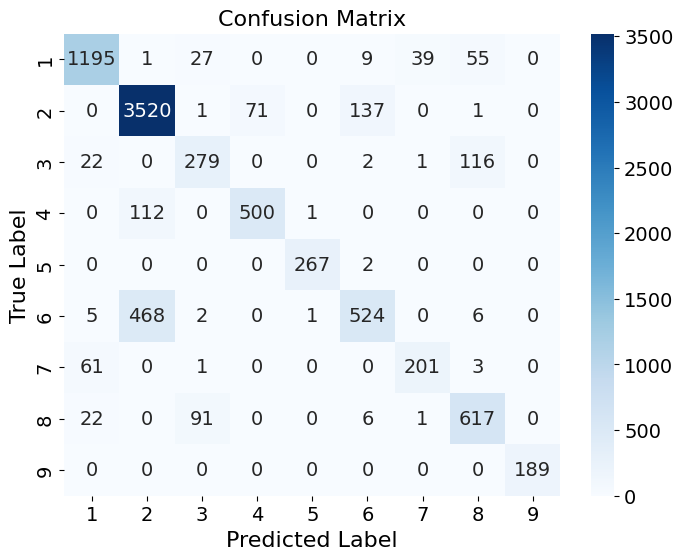

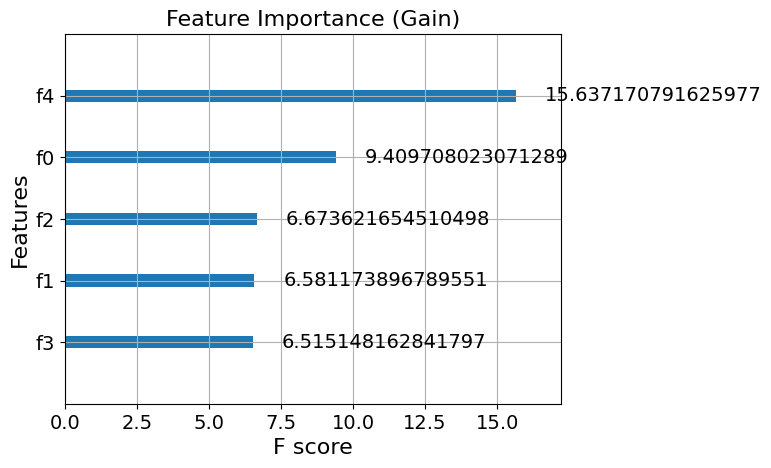

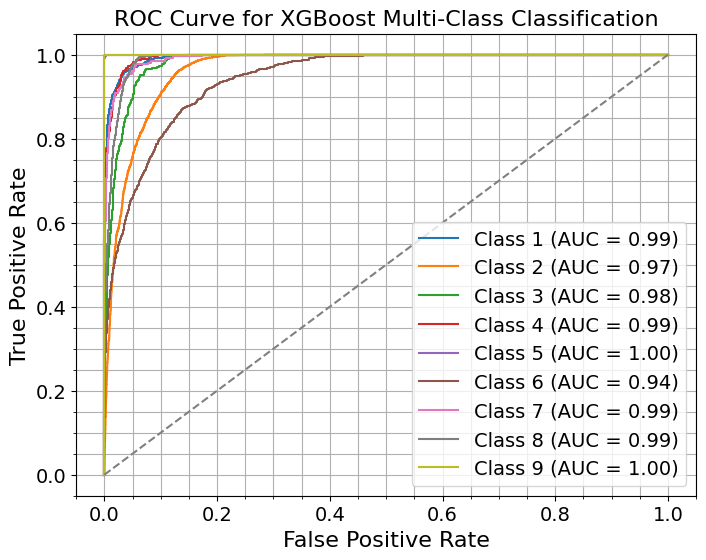

In [ ]:
## Running on Imbalanced Data:

imbalanced_original_data = valid_hsi_data_subsetted
imbalanced_class_labels = valid_gt_pixels

XGBoost_classification(imbalanced_original_data, imbalanced_class_labels)


<div style="font-family: 'TeX Gyre Termes', serif; color: black; font-size: 18px;">

**Running XGBoost On Imbalanced Data:** 

*XGBoost* works by creating chain of trees based on the errors (residuals) of preceding tree(s). The final prediction will be based on the contribution from each tree. The results of running XGBoost classification on Imbalanced (original data) are shown above. The results are good enough based on the training and testing accuracies i.e. 93% and 85% respectively. The confusion matrix shows accuracies of testing samples from all classes. Most of the samples in each classes are classified correctly (shown along the diagonal). A noticeable confusion between class-2 (Meadows) and class-6 (Bare soil) can be seen with 468 samples from class Bare-soil predicted as Meadows which can be tied to the similarity in their spectra. Similarly, There are other misclassification between classes which resembles in their spectra like *Gravel and Self-Blocking Bricks*, *Bitumen and Asphalt* and so on. The ROC curve shows above 0.90 AUC for all the classes with perfect classification for *Class-5(Painted Metal Sheets)* and *Class-9(Shadows)*. From the feature importance plot we can see that the important band for classification are: *1. NIR*, *2. Blue band*, *3. Red Band*, *4. Green Band* and *5. Red-Edge Band* respectively. Overall the classification is reliable but could be made better for testing dataset by balancing the dataset. 

Reference on XGBoost: https://medium.com/low-code-for-advanced-data-science/xgboost-explained-a-beginners-guide-095464ad418f
</div>

Train class distribution: {np.uint8(1): np.int64(758), np.uint8(2): np.int64(758), np.uint8(3): np.int64(757), np.uint8(4): np.int64(757), np.uint8(5): np.int64(757), np.uint8(6): np.int64(758), np.uint8(7): np.int64(757), np.uint8(8): np.int64(758), np.uint8(9): np.int64(758)}
Test class distribution: {np.uint8(1): np.int64(189), np.uint8(2): np.int64(189), np.uint8(3): np.int64(190), np.uint8(4): np.int64(190), np.uint8(5): np.int64(190), np.uint8(6): np.int64(189), np.uint8(7): np.int64(190), np.uint8(8): np.int64(189), np.uint8(9): np.int64(189)}
Train size: (6818, 5), Test size: (1705, 5)

Training Performance:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       758
           2       1.00      1.00      1.00       758
           3       0.99      0.99      0.99       757
           4       1.00      1.00      1.00       757
           5       1.00      1.00      1.00       757
           6       1.00      1.00      1.00       7

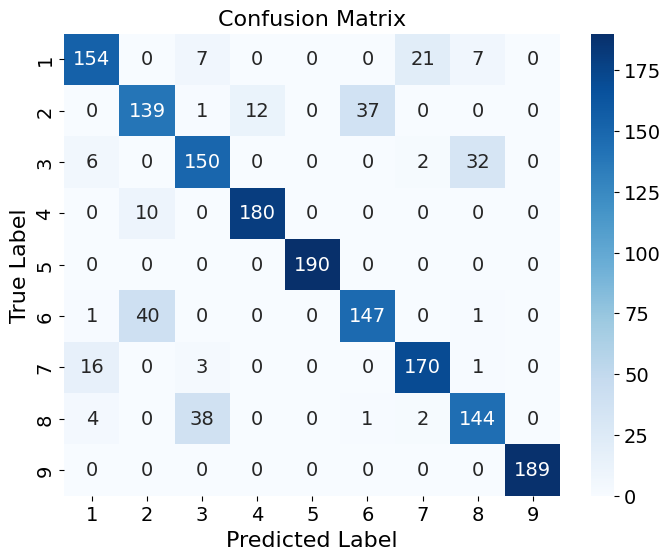

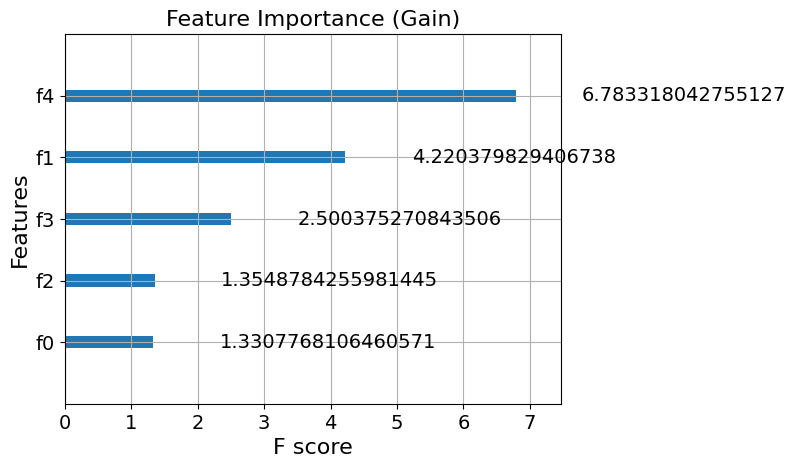

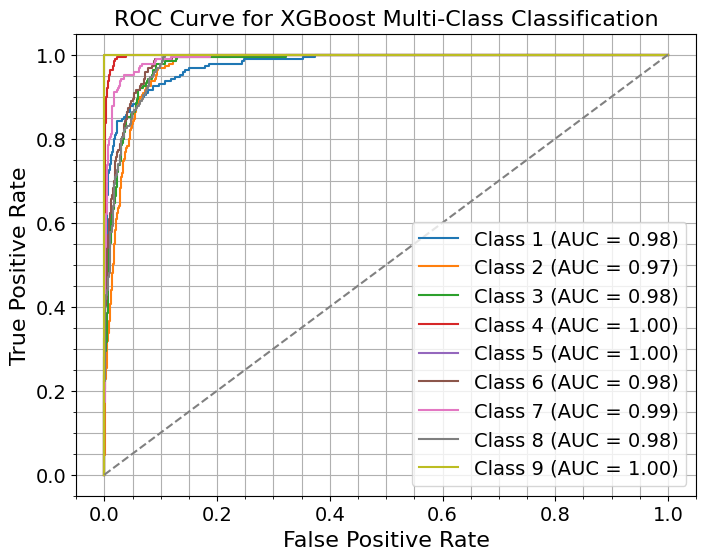

In [ ]:
## Running On Undersampled Data:

XGBoost_classification(undersampled_original_data, undersampled_original_data_labels)

<div style="font-family: 'TeX Gyre Termes', serif; color: black; font-size: 18px;">

**Running XGBoost On Balanced(Undersampled) Data:** 
 
 We ran same XGBoost classification but now on undersampled data where there is equal representation of each classes present in the dataset. We can see clear improvement in the result with almost perfect training accuray (100%) and improved testing accuracy (86%). Confusion among classes are similar as that of earlier case. Interestingly, the feature importance changed when we balance the data. The importance feature here in their order of importance are:  *1. NIR*, *2. Green Band *, *3. Red-Edge Band*, *4. Red Band * and *5. Blue band* respectively. This change likely occurred because balancing the dataset changed how frequently the algorithm "sees" samples from different classes. When a class with high values in certain features becomes more represented, the model has more opportunities to learn from those features, increasing their relative importance in decision-making (**paraphrased statement**). Moreover the AUC for all the classes are now above 0.97 elaborating the improvement in testing data when balancing is performed.

 ---
 ---
</div>